In [30]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import wfdb

from collections import Counter

## check annotation type and number of one record

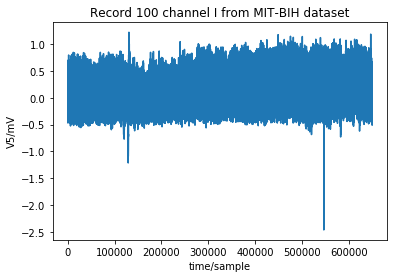

In [2]:
# read a wfdb record and plot the signal
record = wfdb.rdrecord('100', sampfrom=0, sampto='end', channels=[1], pb_dir='mitdb')
wfdb.plot_wfdb(record=record, title='Record 100 channel I from MIT-BIH dataset')

In [3]:
# rdsamp function reads in certain channels and sections of the WFDB record
# and returns a numpy array and a dictionary
signals, fields = wfdb.rdsamp('100', sampfrom=0, sampto='end', channels=[1], pb_dir='mitdb')
display(signals)
display(fields)

array([[-0.065],
       [-0.065],
       [-0.065],
       ..., 
       [-0.365],
       [-0.335],
       [ 0.   ]])

{'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'],
 'fs': 360,
 'sig_name': ['V5'],
 'units': ['mV']}

In [4]:
# check data shape
signals.shape

(650000, 1)

In [5]:
# check data type
signals.dtype

dtype('float64')

In [15]:
# Read a WFDB annotation file into a wfdb.Annotation object, and plot the samples
annotation = wfdb.rdann('100', 'atr', sampfrom=0, sampto=None, shift_samps=True, pb_dir='mitdb')
annotation.fs = 360

In [16]:
# "sample" method returns a numpy array containing the annotation locations in samples
# relative to the beginning of the record
annotation.sample

array([    18,     77,    370, ..., 649484, 649734, 649991])

In [17]:
# check data shape
annotation.sample.shape

(2274,)

In [18]:
# check list length
len(annotation.symbol)

2274

In [19]:
# unique symbols in the symbol list
# + means Rhythm change
# 'A' means Atrial premature beat
# 'N' means Normal beat
# 'V' means Premature ventricular contraction

Counter(annotation.symbol).keys()

dict_keys(['+', 'N', 'A', 'V'])

In [20]:
# how many of each symbol in the list
# there are 2239 normal beats, 33 atrial premature beats and 1 PVC beat
# in the "100" record of MIT-BIH database

Counter(annotation.symbol).values()

dict_values([1, 2239, 33, 1])

In [22]:
# get the location of the PVC beat
annotation.symbol.index('V')

1907

In [24]:
# get the time-stamp of the PVC beat
annotation.sample[1907]

546792

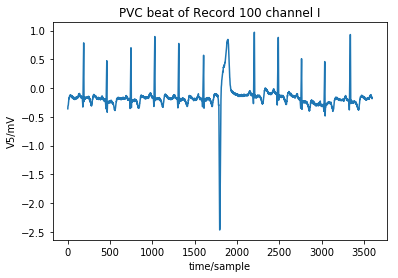

In [25]:
# get 10-second window of the PVC beat (5 seconds before and after)
pvc_record = wfdb.rdrecord('100', sampfrom=(546792-360*5), sampto=(546792+360*5), channels=[1], pb_dir='mitdb')
wfdb.plot_wfdb(record=pvc_record, title='PVC beat of Record 100 channel I')

## check annotation type and number of all records

In [2]:
# check every MIT-BIH data record to identify the type and number of annotations
# get all the record names in a list
namelist = []
namelist = namelist + list(range(100,125,1)) + list(range(200,235,1))
for num in [110,120,204,206,211,216,218,224,225,226,227,229]:
    namelist.remove(num)

len(namelist)

48

In [13]:
# check all records
for record in namelist:
    annotation = wfdb.rdann(str(record), 'atr', sampfrom=0, sampto=None, shift_samps=True, pb_dir='mitdb')
    print('Record', record, Counter(annotation.symbol))
    

Record 100 Counter({'N': 2239, 'A': 33, '+': 1, 'V': 1})
Record 101 Counter({'N': 1860, '~': 4, '|': 4, 'A': 3, 'Q': 2, '+': 1})
Record 102 Counter({'/': 2028, 'N': 99, 'f': 56, '+': 5, 'V': 4})
Record 103 Counter({'N': 2082, '~': 6, 'A': 2, '+': 1})
Record 104 Counter({'/': 1380, 'f': 666, 'N': 163, '+': 45, '~': 37, 'Q': 18, 'V': 2})
Record 105 Counter({'N': 2526, '~': 88, 'V': 41, '|': 30, 'Q': 5, '+': 1})
Record 106 Counter({'N': 1507, 'V': 520, '+': 41, '~': 30})
Record 107 Counter({'/': 2078, 'V': 59, '~': 2, '+': 1})
Record 108 Counter({'N': 1739, '~': 41, 'V': 17, 'x': 11, '|': 8, 'A': 4, 'F': 2, '+': 1, 'j': 1})
Record 109 Counter({'L': 2492, 'V': 38, 'F': 2, '~': 2, '+': 1})
Record 111 Counter({'L': 2123, '~': 8, '+': 1, 'V': 1})
Record 112 Counter({'N': 2537, '~': 10, 'A': 2, '+': 1})
Record 113 Counter({'N': 1789, 'a': 6, '+': 1})
Record 114 Counter({'N': 1820, 'V': 43, 'A': 10, '~': 7, 'F': 4, '+': 3, 'J': 2, '|': 1})
Record 115 Counter({'N': 1953, '|': 6, '~': 2, '+': 1})

## slice 10-seconds window for every records

In [26]:
# define a function that takes in record signal and annotation
# and returns 10-seconds window signal value list and 1-or-0 annotation list

def window10sec (signals, annotation):
    """
    this function gives a 10-seconds window (5s before, 5s after the annotation mark)
    of the ECG signals and assign value 1 if it's PVC beat and 0 otherwise
    parameter: signals: numpy array containing heart beat record values
               annotation: wfdb.annotation object containing heart beat annotations
    return: two lists
            siglist: a list of lists of length 3600 
            annlist: a list containing 1 if PVC beat, 0 otherwise
    """
    siglist = []
    annlist = []
    
    #loop through the annotation.symbol list
    for i in range(len(annotation.symbol)):
        timestamp = annotation.sample[i] #get the timestamp
        
        #test if that timestamp can have 5 seconds before and after window
        windowStart = timestamp - 5*annotation.fs
        windowEnd = timestamp + 5*annotation.fs
        if windowStart >= 0 & windowEnd <= len(signals):
            if annotation.symbol[i] == 'V':
                siglist.append(signals[windowStart:windowEnd,].flatten().tolist())
                annlist.append(1)
            else:
                siglist.append(signals[windowStart:windowEnd,].flatten().tolist())
                annlist.append(0)
        else:
            continue
    
    return siglist, annlist
    

In [27]:
# loop through all record to get all the 10-seconds window signal list and annotation list
# this could be the training dataset for the neural network model
# this takes minutes to run

ECG_signals = []
PVC_annotations = []

for record in namelist:
    signals, fields = wfdb.rdsamp(str(record), sampfrom=0, sampto='end', channels=[1], pb_dir='mitdb')
    annotation = wfdb.rdann(str(record), 'atr', sampfrom=0, sampto=None, shift_samps=True, pb_dir='mitdb')
    
    signal_list, annotation_list = window10sec(signals, annotation)
    ECG_signals = ECG_signals + signal_list
    PVC_annotations = PVC_annotations + annotation_list

In [28]:
len(ECG_signals)

112298

In [29]:
len(PVC_annotations)

112298

In [31]:
# there are 7112 PVC 10-seconds window, 105186 non-PVC 10-seconds window
Counter(PVC_annotations)

Counter({0: 105186, 1: 7112})